In [1]:
! pip3 install evaluate
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(next((root for root, _, files in os.walk(".") if "dsait4090_project_location" in files), "."))
    print(f'Google Colab: {os.getcwd()}')
except ImportError:
    print(f'Local: {os.getcwd()}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/drive
Google Colab: /content/drive/Othercomputers/macbook_pro/

In [2]:
%load_ext autoreload
%autoreload

import logging
import torch
from torch import nn
from time import time

from src.models.deberta_v3 import DEBERTA_V3_CONFIG
from src.models.flant5 import FLAN_T5_CONFIG
from src.models.elastic_roberta import ELASTIC_ROBERTA_CONFIG
from src.models.bart_large_mnli import BART_LARGE_MNLI_CONFIG
from src.models.gpt2 import GPT2_CONFIG
from src.models.roberta_large_mnli import ROBERTA_LARGE_MNLI_CONFIG
from src.common import DATA_PATH, read_data, get_device, DOC, NO_DECOMPOSITION, GPT3_5_TURBO, FLANT5
from src.classification_training import ClassificationTraining
from src.quantemp_processor import QuantempProcessor

logging.basicConfig(level=logging.ERROR)

device = get_device()

def data_path(decomposition: str, split: str):
    if decomposition == 'doc':
        path = f'raw_data/{split}_claims.json'
    elif decomposition == 'no_decomposition':
        return f'no_decomposition/{split}_evidences_no_decomposition.json'
    else:
        path = f'{decomposition}/{split}_evidences_decomposed_{decomposition}.json'

    return os.path.join(DATA_PATH, path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CUDA: 1, use Tesla T4


In [3]:
%autoreload

config = [
    (DEBERTA_V3_CONFIG, NO_DECOMPOSITION),
    (DEBERTA_V3_CONFIG, GPT3_5_TURBO),
    (DEBERTA_V3_CONFIG, FLANT5),
]

print(len(config))
for model, decomposition in config:
    print(f'{model["name"]} - {decomposition}')

3
deberta_v3 - no_decomposition
deberta_v3 - gpt3.5-turbo
deberta_v3 - flant5


(1 / 3)  DEBERTA_V3 | NO_DECOMPOSITION   


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

no_decomposition


  0%|          | 0/9935 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/3084 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/2495 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


config.json:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Starting new training from epoch 1

EPOCH 1


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.819 | 62.07
   eval:  0.753 | 65.76
Saved best model: best_model_01


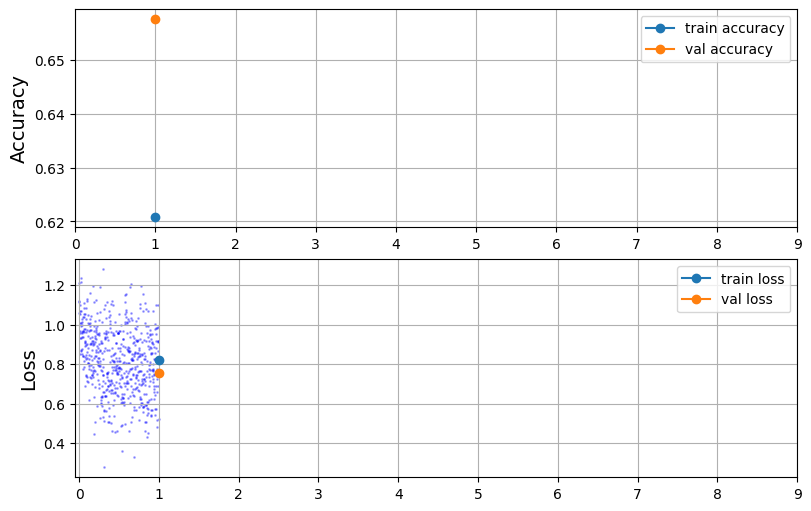


EPOCH 2


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.690 | 69.33
   eval:  0.759 | 66.46
Saved best model: best_model_02


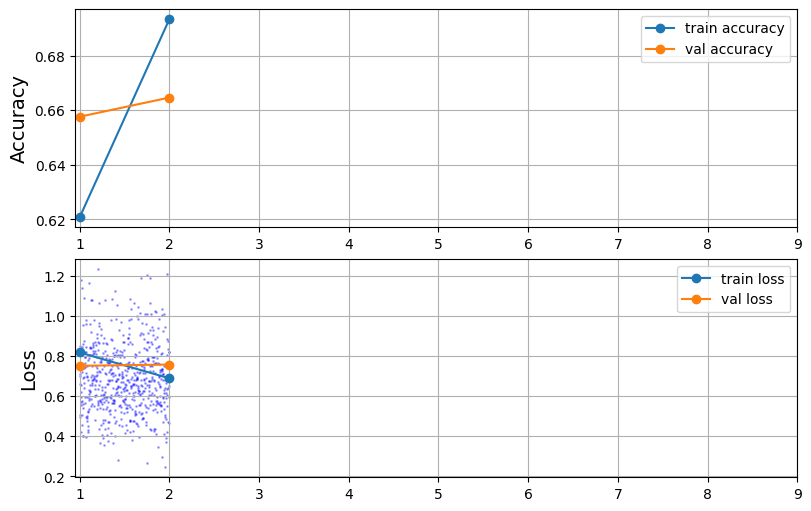


EPOCH 3


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.555 | 76.40
   eval:  0.802 | 65.19


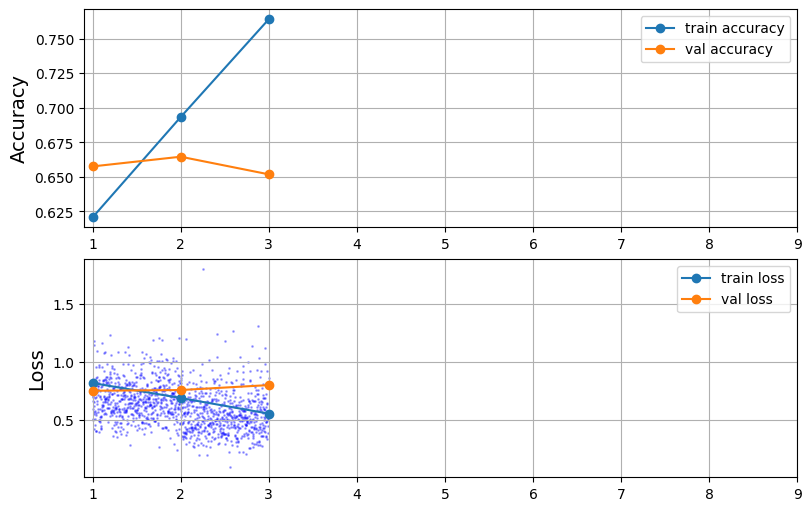

Early stopping counter: 1/2

EPOCH 4


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.417 | 82.88
   eval:  0.908 | 64.23


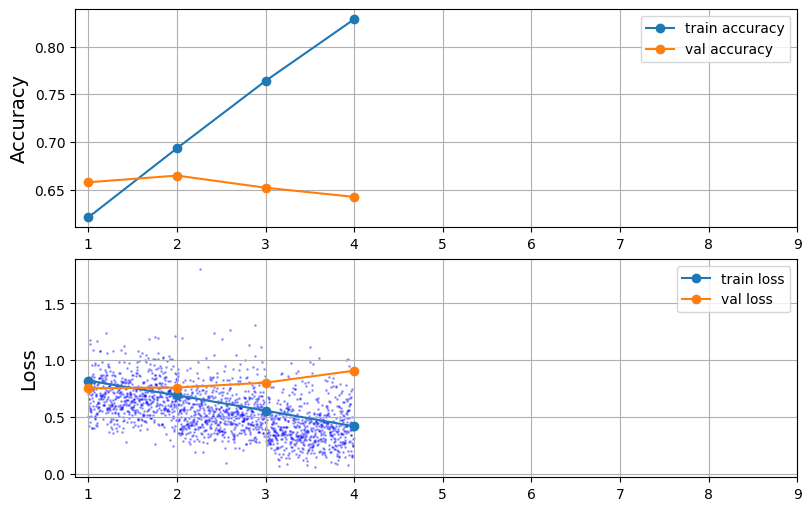

Early stopping counter: 2/2
Loading model: best_model_02


  0%|          | 0/39 [00:00<?, ?it/s]

Saved to output/deberta_v3_no_decomposition
Time: 42.16 min
(2 / 3)  DEBERTA_V3 | GPT3.5-TURBO   
decomposition


  0%|          | 0/9935 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/3084 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/2495 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Starting new training from epoch 1

EPOCH 1


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.818 | 62.21
   eval:  0.772 | 63.58
Saved best model: best_model_01


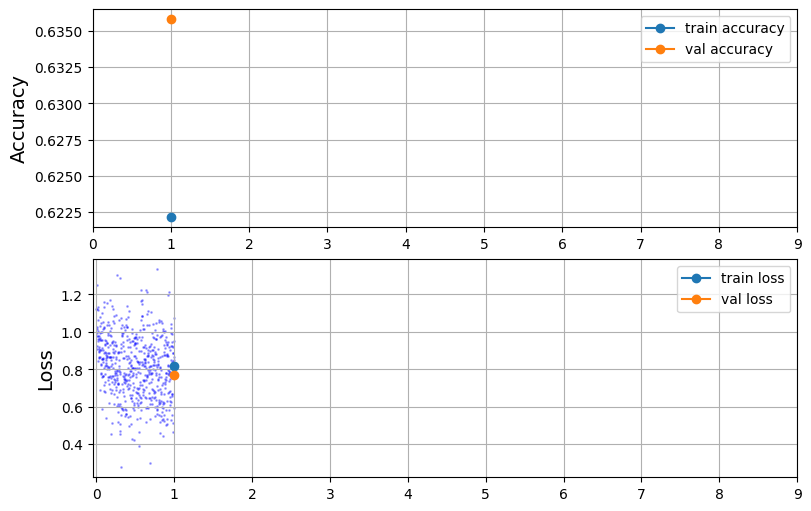


EPOCH 2


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.702 | 68.87
   eval:  0.782 | 66.26
Saved best model: best_model_02


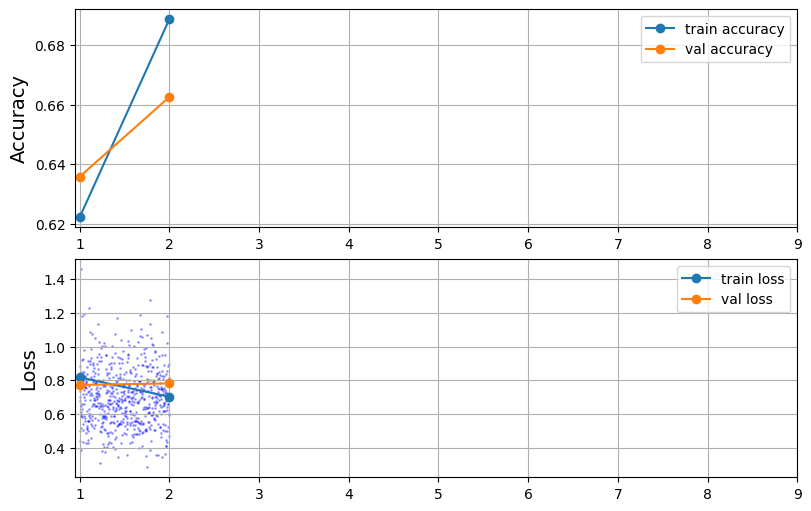


EPOCH 3


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.593 | 74.53
   eval:  0.798 | 65.68


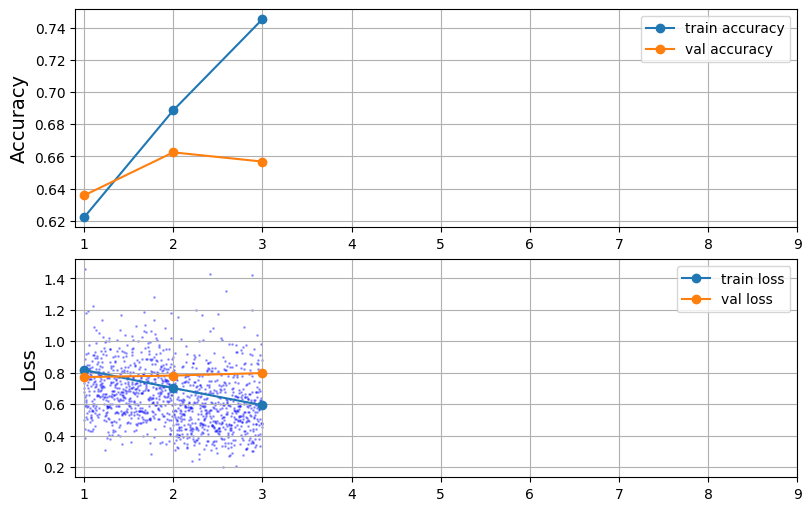

Early stopping counter: 1/2

EPOCH 4


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.469 | 80.63
   eval:  0.927 | 65.37


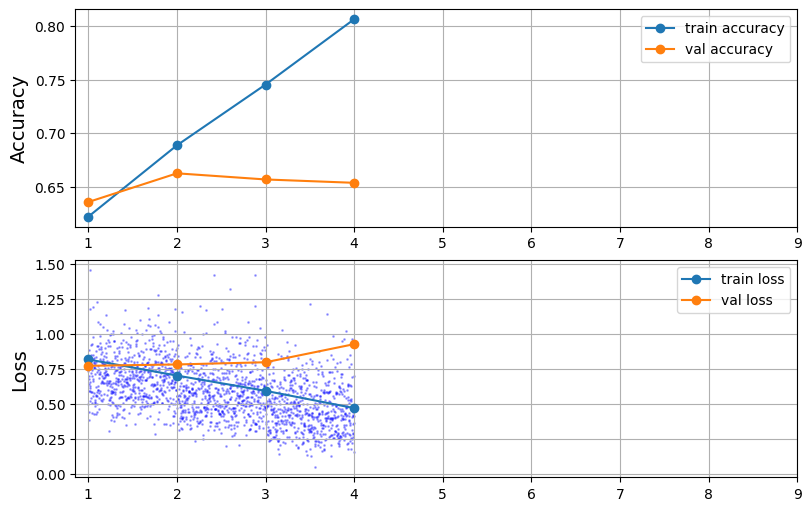

Early stopping counter: 2/2
Loading model: best_model_02


  0%|          | 0/39 [00:00<?, ?it/s]

Saved to output/deberta_v3_gpt3.5-turbo
Time: 42.94 min
(3 / 3)  DEBERTA_V3 | FLANT5   
decomposition


  0%|          | 0/9935 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/3084 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/2495 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Starting new training from epoch 1

EPOCH 1


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.818 | 61.92
   eval:  0.758 | 65.97
Saved best model: best_model_01


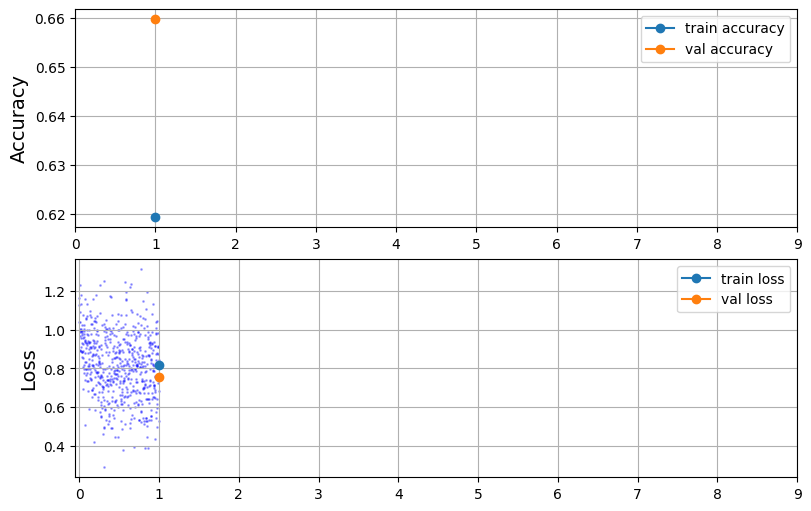


EPOCH 2


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.705 | 68.18
   eval:  0.773 | 66.32
Saved best model: best_model_02


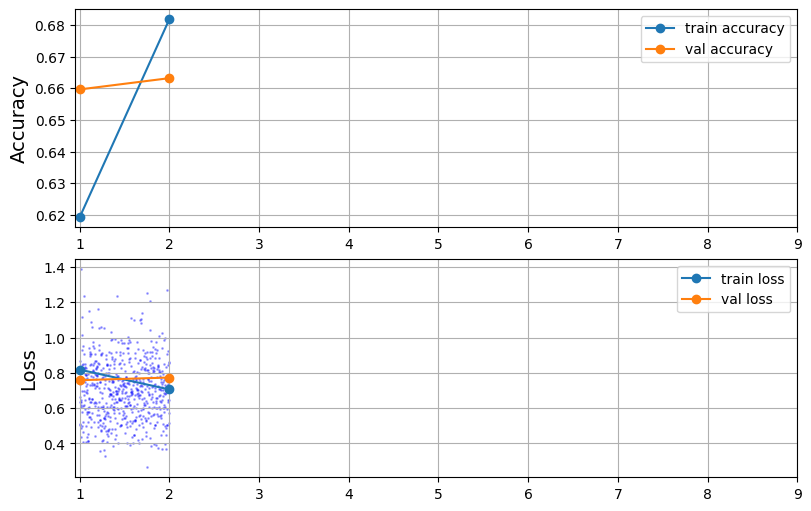


EPOCH 3


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.586 | 74.89
   eval:  0.793 | 66.41
Saved best model: best_model_03


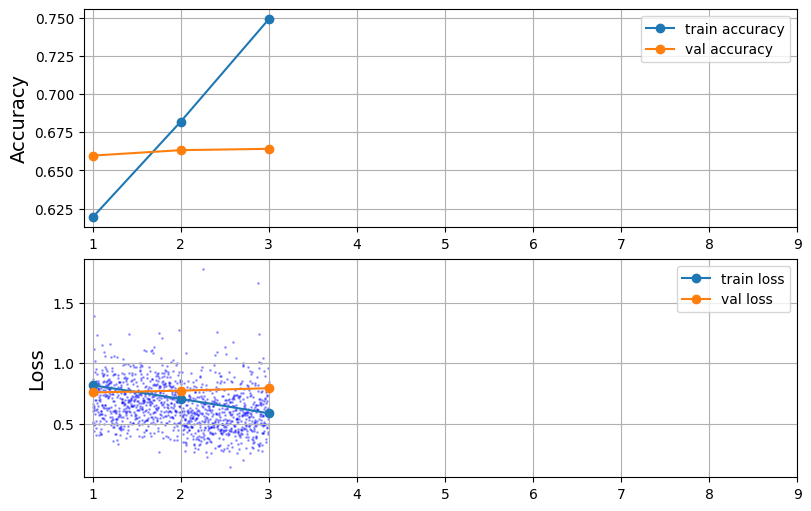


EPOCH 4


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.449 | 81.27
   eval:  0.964 | 66.71
Saved best model: best_model_04


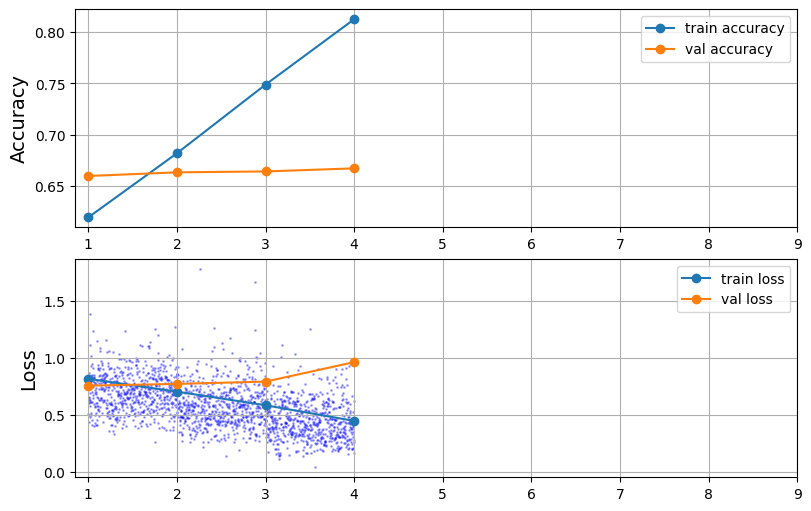


EPOCH 5


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.321 | 87.22
   eval:  1.135 | 61.88


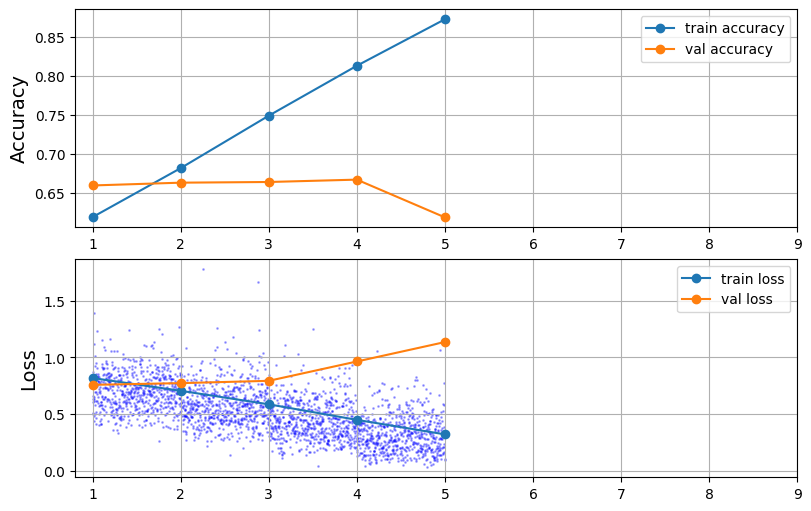

Early stopping counter: 1/2

EPOCH 6


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.226 | 91.46
   eval:  1.190 | 66.34


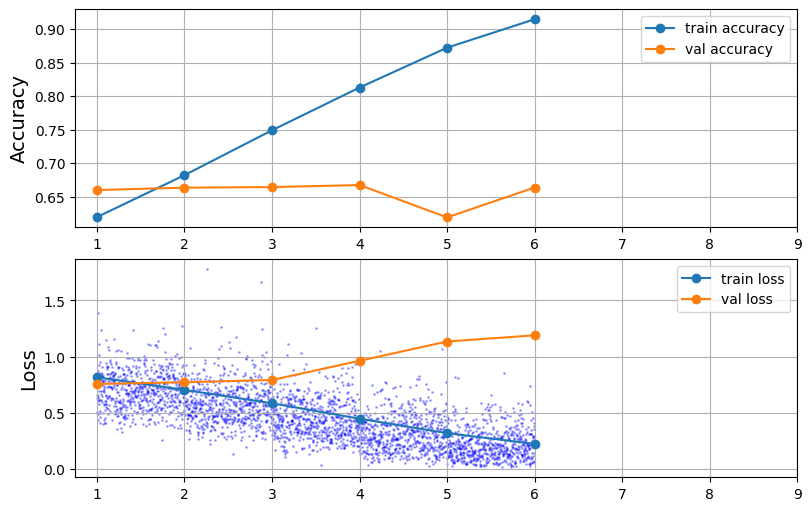

Early stopping counter: 2/2
Loading model: best_model_04


  0%|          | 0/39 [00:00<?, ?it/s]

Saved to output/deberta_v3_flant5
Time: 63.59 min


In [4]:
%autoreload

DATA_LIMIT = None

for i, (model_config, decomposition) in enumerate(config):
    t0 = time()
    model_name = model_config['name']
    model_type = model_config['model']
    tokenizer_type = model_config['tokenizer']

    print(f"{'='*60}\n({i+1} / {len(config)})  {model_name.upper()} | {decomposition.upper()}   \n{'='*60}")

    train_claims = read_data(data_path(decomposition, 'train'))[:DATA_LIMIT]
    val_claims = read_data(data_path(decomposition, 'val'))[:DATA_LIMIT]
    test_claims = read_data(data_path(decomposition, 'test'))[:DATA_LIMIT]

    data_processor = QuantempProcessor(tokenizer_type(), decomposition=decomposition)
    train_dataset = data_processor.transform(train_claims)
    val_dataset = data_processor.transform(val_claims)
    test_dataset = data_processor.transform(test_claims)

    model = model_type().to(device)

    training = ClassificationTraining(
        model_name=f"{model_name}_{decomposition}",
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        model=model,
        optimizer=torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8),
        loss_function=nn.CrossEntropyLoss(),
        batch_size=16,
        device=device,
        random_state=49
    )

    training.start_new_training()
    training.train(epochs=20, patience=2)
    training.evaluate_best_model(test_claims, test_dataset)

    t1 = time()
    print(f"Time: {(t1 - t0) / 60:.2f} min")

